In [245]:
from pathlib import Path
import pickle
import itertools
import json

import numpy as np
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

from ruben import PersistenceDiagram

In [212]:
outdir = Path('../out/')
ref_file = Path(
    "/Users/otis/Documents/rubens_speelhoekje/google/google_data/public_data/reference_data/task1_v4/model_configs.json")

In [213]:
from gtda.diagrams import PersistenceEntropy, ComplexPolynomial

def features_for_dim(pd, dim):
	# b: birth, d: death
	b, d, _ = pd[pd[:,2] == dim].T
	if dim == 0:
		assert d[-1] == np.inf
		d[-1] = 1
	with np.errstate(invalid='ignore', divide='ignore'):
		return [
			mean_bd := np.c_[b, d].mean(axis=0),
			mean_bd**2,
			np.nan_to_num(1/mean_bd + np.log(mean_bd)), # fix divide by zero
			np.c_[b, d].std(axis=0),
			[np.mean(b - d)],
			[np.mean(b - d)**2],
			[np.mean((b + d) / 2)],
			[np.mean((b + d) / 2)**2],
		]

features = {
	'avg_birth_death': 2,
	'avg_birth_death_squared': 2,
	'avg_birth_death_inverted' : 2,
	'std_birth_death': 2,
	'avg_life': 1,
	'avg_life_squared': 1,
	'avg_half_life': 1,
	'avg_half_life_squared': 1
}

def features_all_dims(pd):
	arrs = [np.concatenate(features_for_dim(pd, dim)) for dim in (0, 1)]
	return np.vstack(arrs)

In [248]:
gen_gaps = {
	'model_' + k: v['metrics']['train_acc'] - v['metrics']['test_acc']
	for k, v in json.loads(ref_file.read_text()).items()
}

def get_labeled_data(dir, exclude=[]):
	candidates = [dir / (model + '.pd.npy') for model in gen_gaps]
	files = [file for file in candidates if file.exists() and not file in exclude]
	models = [file.stem.split('.')[0] for file in files]
	if len(models) < len(gen_gaps):
		print('Missing ', [m for m in gen_gaps if m not in models])
	pds = [*map(np.load, files)]
	X = np.stack([*map(features_all_dims, pds)])
	y = np.array([gen_gaps[m] for m in models])
	return X, y

In [249]:
def feature_mask(included):
	return np.concatenate([
		np.full(length, 1 if feature in included else 0)
		for feature, length in features.items()
	])

def run_experiment(X, y, tries, model_fn):
	global features
	combinations = itertools.chain(*(
		itertools.combinations(features.keys(), r)
		for r in range(1, len(features) + 1)
	))
	# seeds = np.random.default_rng().integers(2**32 - 1, size=tries)
	results = {combo: [] for combo in combinations}
	splits = [*ShuffleSplit(100, test_size=0.3).split(X)]
	for combo in tqdm(results):
		# Should I do cross-validation here?
		# and vary the splits over the different combos
		# or keep them the same?
		X_masked = X[:,:,np.where(feature_mask(combo))[0]]
		X_flattened = X_masked.reshape((len(X), -1))
		for train, test in splits:
			reg = model_fn().fit(X_flattened[train], y[train])
			results[combo] += [reg.score(X_flattened[test], y[test])]
	return results

In [293]:
all_results = {}

for dir in (outdir / 'task1').iterdir():
	if not dir.is_dir() or dir.name == 'stratifiedkmeans':
		continue
	print('Sampler: ', dir.name)
	X, y = get_labeled_data(dir)
	results = run_experiment(X, y, 200, LinearRegression)
	all_results[dir.name] = [
		max(results.items(), key=lambda x: len(x[0])), 		# all features
		max(results.items(), key=lambda x: np.mean(x[1]))	# best selection
	]
	print('All features: ', np.mean(all_results[dir.name][0][1]))
	print('Best selection:', np.mean(all_results[dir.name][1][1]))
	print(all_results[dir.name][1][0])
	print('\n\n')

Sampler:  stratifiedrandom
Missing  ['model_156', 'model_157']


100%|██████████| 255/255 [00:58<00:00,  4.34it/s]


All features:  0.7591664534412982
Best selection: 0.7975687273534657
('avg_birth_death_squared', 'avg_birth_death_inverted', 'std_birth_death', 'avg_life', 'avg_half_life_squared')



Sampler:  importance
Missing  ['model_156', 'model_157', 'model_158', 'model_220', 'model_221']


100%|██████████| 255/255 [01:08<00:00,  3.73it/s]


All features:  0.40373892310176424
Best selection: 0.7517526592533188
('avg_birth_death_squared', 'std_birth_death', 'avg_life_squared', 'avg_half_life', 'avg_half_life_squared')



Sampler:  random
Missing  ['model_28', 'model_29', 'model_156', 'model_157', 'model_220', 'model_221']


100%|██████████| 255/255 [01:18<00:00,  3.27it/s]

All features:  0.7653398190681493
Best selection: 0.8094089396863237
('avg_birth_death', 'avg_birth_death_inverted', 'std_birth_death', 'avg_half_life', 'avg_half_life_squared')





Text(0.5, 1.0, 'Best selection')

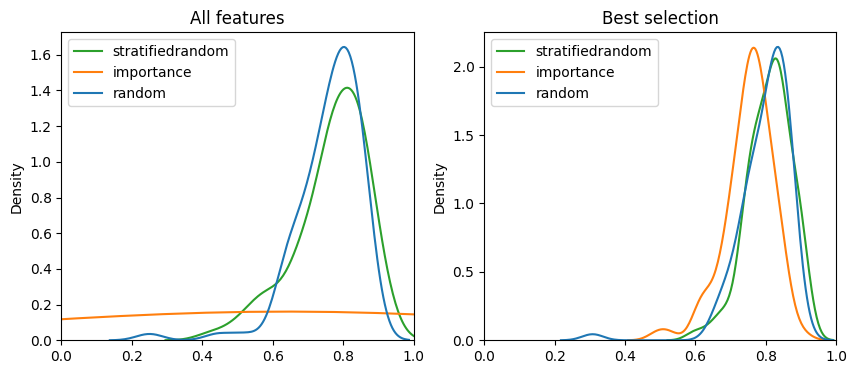

In [294]:
def plot_kdes(samplers, dists, bw=None, ax=None):
	ax = sns.kdeplot(dists, ax=ax)
	ax.legend(samplers)
	ax.set_xlim([0,1])
	return ax

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_kdes(samplers=list(all_results.keys()),
		  dists=[x[0][1] for x in all_results.values()],
		  ax=ax1, bw=0.2)
ax1.set_title('All features')

plot_kdes(samplers=list(all_results.keys()),
		  dists=[x[1][1] for x in all_results.values()],
		  ax=ax2, bw=0.2)
ax2.set_title('Best selection')